In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [126]:
!pip install pyngrok --quiet
!pip install mlflow --quiet

import mlflow
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

# create remote tunnel using ngrok.com to allow local port access

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "1r8VzJGvVkDqYJDLNyNR12FZAIN_bYtBiBQEXBPv8DnzxKTB"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

def eval_metrics(actual, pred):
  acc = accuracy_score(actual, pred)
  f1 = f1_score(actual, pred)
  precision = precision_score(actual, pred)
  recall = recall_score(actual, pred)
  return {'accuracy':acc, 'f1':f1, 'precision':precision, 'recall':recall}

def mlflow_save(experiment_id, params, metrics, model, name):
  with mlflow.start_run(experiment_id=experiment_id) as run:
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(model, 'sklearn-model')
    mlflow.set_tags({'Name':name})

def train_validation_test_split(X, y):
  X = X.sample(frac=1, random_state=123)
  y = y.sample(frac=1, random_state=123)
  if(len(X)==len(y)):
    length = len(X)
    X_train = X.iloc[:int(0.6*length)]
    X_validation = X.iloc[int(0.6*length):int(0.8*length)]
    X_test = X.iloc[:int(0.8*length)]
    y_train = y.iloc[:int(0.6*length)]
    y_validation = y.iloc[int(0.6*length):int(0.8*length)]
    y_test = y.iloc[:int(0.8*length)]
    return X_train, X_validation, X_test, y_train, y_validation, y_test
  else:
    print("X and y length must be equal!")

MLflow Tracking UI: https://cf3635f5aa33.ngrok.io


In [136]:
DEMO = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/DEMO_J.XPT', index='SEQN')
DEMO = DEMO[['RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'DMDMARTL']]

BMX = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/BMX_J.XPT', index='SEQN')
BMX = BMX[['BMXWT', 'BMXHT']]

BPX = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/BPX_J.XPT', index='SEQN') 
BPX = BPX[['BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2']]

BPQ = pd.read_sas('/content/gdrive/My Drive/11º Período/Ciencia de Dados/BPQ_J.XPT', index='SEQN') 
BPQ = BPQ[['BPQ020', 'BPQ080']]

df = pd.merge(DEMO, BMX, left_index=True, right_index=True, how='inner')
df = pd.merge(df, BPX, left_index=True, right_index=True, how='inner')
df = pd.merge(df, BPQ, left_index=True, right_index=True, how='inner')

df.columns = ['Gender','Age','Education','Marital','Weight','Height','Systole1','Diastole1','Systole2','Diastole2','High_Pressure','High_Cholesterol']
df.Gender = df.Gender.replace({1.0: 'Male', 2.0: 'Female'})
df.Education = df.Education.replace({1.0: '-9th', 2.0: '9-11th', 3.0: 'High School', 4.0: 'Some College', 5.0: 'Graduate+', 7.0: 'Refused', 8.0: 'Don\'t Know'})
df.Marital = df.Marital.replace({1.0: 'Married', 2.0: 'Widowed', 3.0: 'Divorced', 4.0: 'Separated', 5.0: 'Never Married', 6.0: 'Living With Partner', 77: 'Refused', 99: 'Don\'t Know'})
df.High_Pressure = df.High_Pressure.replace({1.0: 'Yes', 2.0: 'No', 7.0: 'Refused', 9.0: 'Don\'t Know'})
df.High_Cholesterol = df.High_Cholesterol.replace({1.0: 'Yes', 2.0: 'No', 7.0: 'Refused', 9.0: 'Don\'t Know'})
display(df.head())
print('Linhas = {}\nColunas = {}'.format(df.shape[0], df.shape[1]))

,Gender,Age,Education,Marital,Weight,Height,Systole1,Diastole1,Systole2,Diastole2,High_Pressure,High_Cholesterol
SEQN,,,,,,,,,,,,
93705.0,Female,66.0,9-11th,Divorced,79.5,158.3,NaN,NaN,NaN,NaN,Yes,No
93706.0,Male,18.0,NaN,NaN,66.3,175.7,112.0,74.0,114.0,70.0,No,No
93708.0,Female,66.0,-9th,Married,53.5,150.2,NaN,NaN,138.0,78.0,Yes,Yes
93709.0,Female,75.0,Some College,Widowed,88.8,151.1,120.0,66.0,118.0,66.0,Yes,No
93711.0,Male,56.0,Graduate+,Married,62.1,170.6,108.0,68.0,94.0,68.0,No,Yes


Linhas = 5828
Colunas = 12


In [137]:
df = df[df.High_Pressure.isin(['Yes','No'])]
df = df.dropna()
print('Linhas restantes = {}'.format(df.shape[0]))

Linhas restantes = 4509


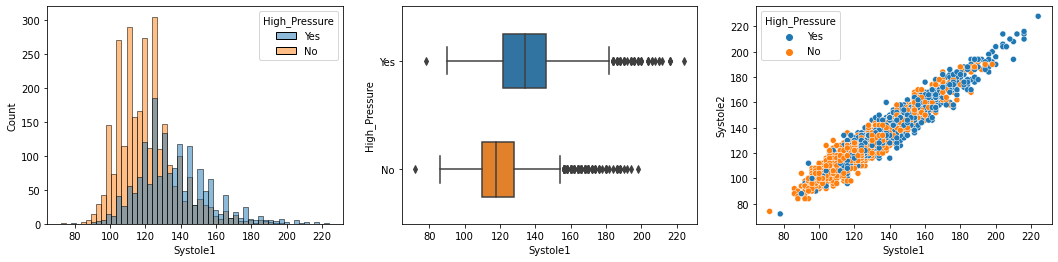

In [138]:
_, axes = plt.subplots(1, 3, figsize=(18,4))
sns.histplot(data=df, x='Systole1', hue='High_Pressure', multiple='layer', ax=axes[0]);
sns.boxplot(data=df, x='Systole1', y='High_Pressure', width=0.5, ax=axes[1]);
sns.scatterplot(data=df, x='Systole1', y='Systole2', hue='High_Pressure', ax=axes[2]);
plt.show()

In [139]:
df['Gender'] = df['Gender'].astype('category')
df['Education'] = df['Education'].astype('category')
df['Marital'] = df['Marital'].astype('category')
df['High_Pressure'] = df['High_Pressure'].astype('category')
df['High_Cholesterol'] = df['High_Cholesterol'].astype('category')

df['Gender'] = df['Gender'].cat.codes
df['Education'] = df['Education'].cat.codes
df['Marital'] = df['Marital'].cat.codes
df['High_Pressure'] = df['High_Pressure'].cat.codes
df['High_Cholesterol'] = df['High_Cholesterol'].cat.codes

In [142]:
X = df.drop(columns='High_Pressure')
y = df.High_Pressure

X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(X, y)

mlflow.set_experiment('Validation1')
experiment_id = mlflow.get_experiment_by_name('Validation1').experiment_id

INFO: 'Validation1' does not exist. Creating a new experiment


In [143]:
for n_estimators in [1,10,100,1000]:
    modelRF = RandomForestClassifier(n_estimators=n_estimators)
    modelRF.fit(X_train, y_train)
    y_pred = modelRF.predict(X_validation)

    mlflow_save(experiment_id, {'n_estimators':n_estimators}, eval_metrics(y_validation, y_pred), modelRF, "Random_Forest")

In [148]:
for n_neighbors in range(1,20):
    modelKNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    modelKNN.fit(X_train, y_train)
    y_pred = modelKNN.predict(X_validation)

    mlflow_save(experiment_id, {'n_neighbors':n_neighbors}, eval_metrics(y_validation, y_pred), modelKNN, "k-NN")

In [149]:
for hidden_layer_sizes in [(100,),(100,100,),(100,100,100,)]:
  for learning_rate_init in [0.01,0.001]:
    modelMLP = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init, activation='tanh', early_stopping=True, max_iter=1000, validation_fraction=0.2, solver='sgd')
    modelMLP.fit(X_train, y_train)
    y_pred = modelMLP.predict(X_validation)

    mlflow_save(experiment_id, {'hidden_layer_sizes':hidden_layer_sizes, 'learning_rate_init':learning_rate_init}, eval_metrics(y_validation, y_pred), modelMLP, "MLP")

In [150]:
modelNB = GaussianNB()
modelNB.fit(X_train, y_train)
y_pred = modelNB.predict(X_validation)

mlflow_save(experiment_id, {}, eval_metrics(y_validation, y_pred), modelNB, "Naive_Bayes")

In [192]:
filter_string = "tags.Name = 'Random_Forest'"
resultRF = mlflow.search_runs([experiment_id], filter_string=filter_string, order_by=["metrics.accuracy DESC"])
print('\nResultado dos modelos Random Forest sobre o conjunto de validação:\n')
display(resultRF[['tags.Name','params.n_estimators','metrics.accuracy','run_id']])

bestRF_run_id = resultRF.loc[0,'run_id']
best_modelRF = mlflow.sklearn.load_model("mlruns/" + experiment_id + "/" + bestRF_run_id + "/artifacts/sklearn-model/")
y_pred = best_modelRF.predict(X_test)

metrics = eval_metrics(y_pred, y_test) 
print('\nAvaliação do melhor modelo Random Forest sobre o conjunto de teste:\nAccuracy = {}\nF1-score = {}\nPrecision = {}\nRecall = {}'.format(metrics['accuracy'],metrics['f1'],metrics['precision'],metrics['recall']))


Resultado dos modelos Random Forest sobre o conjunto de validação:



,tags.Name,params.n_estimators,metrics.accuracy,run_id
0,Random_Forest,1000,0.746120,d7543b89614c42049199bf1589b3d52b
1,Random_Forest,100,0.746120,01149c98b9244319b99afbeeb2b257af
2,Random_Forest,10,0.709534,a060c5416d4449d4b9777afd6ca2a0c5
3,Random_Forest,1,0.667406,7b5a5356187d44babc8624d8daaebe28



Avaliação do melhor modelo Random Forest sobre o conjunto de teste:
Accuracy = 0.9365123371222622
F1-score = 0.9144564811355994
Precision = 0.9147982062780269
Recall = 0.9141150112023898


In [185]:
filter_string = "tags.Name = 'k-NN'"
resultKNN = mlflow.search_runs([experiment_id], filter_string=filter_string, order_by=["metrics.accuracy DESC"])
print('\nResultado dos modelos k-NN sobre o conjunto de validação:\n')
display(resultKNN[['tags.Name','params.n_neighbors','metrics.accuracy','run_id']])

bestKNN_run_id = resultKNN.loc[0,'run_id']
best_modelKNN = mlflow.sklearn.load_model("mlruns/" + experiment_id + "/" + bestKNN_run_id + "/artifacts/sklearn-model/")
y_pred = best_modelKNN.predict(X_test)

metrics = eval_metrics(y_pred, y_test) 
print('\nAvaliação do melhor modelo k-NN sobre o conjunto de teste:\nAccuracy = {}\nF1-score = {}\nPrecision = {}\nRecall = {}'.format(metrics['accuracy'],metrics['f1'],metrics['precision'],metrics['recall']))



Resultado dos modelos k-NN sobre o conjunto de validação:



,tags.Name,params.n_neighbors,metrics.accuracy,run_id
0,k-NN,15,0.728381,d7d3195d6d514c32b531231b7f662444
1,k-NN,19,0.726164,7a0cf6ce0e294b11b9ad4645172655df
2,k-NN,16,0.725055,dde06d044ed34b1192aa926919715e9a
3,k-NN,14,0.721729,a89739c5de9e49e3bc80b3b3fb86e1f8
4,k-NN,13,0.720621,e640f564ae484e398067423ce2b58c53
5,k-NN,11,0.720621,01fd10085187494182efc167bf2775b6
6,k-NN,12,0.719512,cdedd6886a894c89891a5d1612b36c0e
7,k-NN,17,0.718404,41a067c749da41c0acf2564169d1fdf2
8,k-NN,10,0.717295,8a42d3a8c028482d888a4e5c58a536f6
9,k-NN,9,0.713969,55d08674996c4a069a4cae6798619dc1



Avaliação do melhor modelo k-NN sobre o conjunto de teste:
Accuracy = 0.7610202384252842
F1-score = 0.6707410236822002
Precision = 0.656203288490284
Recall = 0.6859375


In [184]:
filter_string = "tags.Name = 'MLP'"
resultMLP = mlflow.search_runs([experiment_id], filter_string=filter_string, order_by=["metrics.accuracy DESC"])
print('\nResultado dos modelos MLP sobre o conjunto de validação:\n')
display(resultMLP[['tags.Name','params.hidden_layer_sizes','params.learning_rate_init','metrics.accuracy','run_id']])

bestMLP_run_id = resultMLP.loc[0,'run_id']
best_modelMLP = mlflow.sklearn.load_model("mlruns/" + experiment_id + "/" + bestMLP_run_id + "/artifacts/sklearn-model/")
y_pred = best_modelMLP.predict(X_test)

metrics = eval_metrics(y_pred, y_test) 
print('\nAvaliação do melhor modelo MLP sobre o conjunto de teste:\nAccuracy = {}\nF1-score = {}\nPrecision = {}\nRecall = {}'.format(metrics['accuracy'],metrics['f1'],metrics['precision'],metrics['recall']))


Resultado dos modelos MLP sobre o conjunto de validação:



,tags.Name,params.hidden_layer_sizes,params.learning_rate_init,metrics.accuracy,run_id
0,MLP,"(100,)",0.001,0.733925,ecf17e652f154477abecd1a9e23f00f7
1,MLP,"(100, 100, 100)",0.001,0.732816,b6a4483349e4418b8df6f86764947e00
2,MLP,"(100, 100)",0.001,0.731707,29911b7e0ced467299396ef772a94a89
3,MLP,"(100, 100, 100)",0.01,0.727273,93fa24c8fa6d44438dd7753ff8475cec
4,MLP,"(100,)",0.01,0.720621,56015f23bf1d40baa951e48480b15844
5,MLP,"(100, 100)",0.01,0.713969,d8c7763467a94f4aa837c0008d6d1e5b



Avaliação do melhor modelo MLP sobre o conjunto de teste:
Accuracy = 0.728860548932631
F1-score = 0.6143533123028391
Precision = 0.5822122571001495
Recall = 0.6502504173622704


In [183]:
filter_string = "tags.Name = 'Naive_Bayes'"
resultNB = mlflow.search_runs([experiment_id], filter_string=filter_string, order_by=["metrics.accuracy DESC"])
print('\nResultado do modelo Naive Bayes sobre o conjunto de validação:\n')
display(resultNB[['tags.Name','metrics.accuracy','run_id']])

bestNB_run_id = resultNB.loc[0,'run_id']
best_modelNB = mlflow.sklearn.load_model("mlruns/" + experiment_id + "/" + bestNB_run_id + "/artifacts/sklearn-model/")
y_pred = best_modelNB.predict(X_test)

metrics = eval_metrics(y_pred, y_test) 
print('\nAvaliação do melhor modelo Naive Bayes sobre o conjunto de teste:\nAccuracy = {}\nF1-score = {}\nPrecision = {}\nRecall = {}'.format(metrics['accuracy'],metrics['f1'],metrics['precision'],metrics['recall']))


Resultado do modelo Naive Bayes sobre o conjunto de validação:



,tags.Name,metrics.accuracy,run_id
0,Naive_Bayes,0.741685,da805912c5914c5ca55784d8a633bec7



Avaliação do melhor modelo Naive Bayes sobre o conjunto de teste:
Accuracy = 0.7402273357360688
F1-score = 0.6419564386702331
Precision = 0.6278026905829597
Recall = 0.656763096168882
